In [13]:
import numpy as np
import matplotlib.pyplot as plt

import chainer
import chainer.links as L
import chainer.functions as F

In [14]:
from sklearn.datasets import load_iris

dataset = load_iris()

x = dataset.data
t = dataset.target

x = np.array(x, np.float32)
t = np.array(t, np.int32)

In [15]:
from chainer.datasets import TupleDataset

dataset = TupleDataset(x, t)

In [16]:
from chainer.datasets import split_dataset_random

n_train = int(len(dataset) * 0.7)
n_valid = int(len(dataset) * 0.1)

train, valid_test = split_dataset_random(dataset, n_train, seed=0)
valid, test = split_dataset_random(valid_test, n_valid, seed=0)

print('Training dataset size:', len(train))
print('Validation dataset size:', len(valid))
print('Test dataset size:', len(test))

Training dataset size: 105
Validation dataset size: 15
Test dataset size: 30


In [17]:
from chainer.iterators import SerialIterator

batchsize = 32

train_iter = SerialIterator(train, batchsize)
valid_iter = SerialIterator(valid, batchsize, shuffle=False, repeat=False)

In [18]:
class MLP(chainer.Chain):
    
    def __init__(self, n_mid_units=100, n_out=3):
        super().__init__()
        with self.init_scope():
            self.fc1 = L.Linear(None, n_mid_units)
            self.fc2 = L.Linear(n_mid_units, n_mid_units)
            self.fc3 = L.Linear(n_mid_units, n_out)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = self.fc3(h)
        
        return h

In [19]:
from chainer import optimizers
from chainer import training

predictor = MLP()

net = L.Classifier(predictor)

optimizer = optimizers.MomentumSGD(lr=0.1).setup(net)

updater = training.StandardUpdater(train_iter, optimizer, device=-1)

In [20]:
trainer = training.Trainer(updater, (30, 'epoch'), out='results/iris_result1')

In [21]:
from chainer.training import extensions

trainer.extend(extensions.LogReport(trigger=(1, 'epoch'), log_name='log'))
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.dump_graph('main/loss'))
trainer.extend(extensions.Evaluator(valid_iter, net, device=-1), name='val')
trainer.extend(extensions.PrintReport(['epoch', 'iteration', 'main/loss', 'main/accuracy', 'val/main/loss', 'val/main/accuracy', 'fc1/W/data/mean', 'elapsed_time']))
trainer.extend(extensions.PlotReport(['fc1/W/grad/mean'], x_key='epoch', file_name='mean.png'))
trainer.extend(extensions.PlotReport(['main/loss', 'val/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'val/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.extend(extensions.ParameterStatistics(net.predictor.fc1, {'mean': np.mean}, report_grads=True))

In [22]:
trainer.run()

epoch       iteration   main/loss   main/accuracy  val/main/loss  val/main/accuracy  fc1/W/data/mean  elapsed_time
1           4           8.56216     0.382812       1.07173        0.333333           -0.0225341       0.0165359     
2           7           0.980073    0.385417       0.79383        0.6                -0.0808723       0.276239      
3           10          0.63711     0.739583       0.718566       0.6                -0.115641        0.550091      
4           14          0.691829    0.78125        0.927479       0.6                -0.14297         0.841193      
5           17          1.1648      0.5625         0.716022       0.666667           -0.164718        1.11652       
6           20          0.536691    0.708333       0.685632       0.6                -0.179347        1.40979       
7           23          0.62161     0.614583       0.633376       0.6                -0.190672        1.67278       
8           27          2.17195     0.484375       3.53894        

In [31]:
!ls results/iris_result1

accuracy.png
cg.dot
log
loss.png
mean.png
snapshot_epoch-1
snapshot_epoch-10
snapshot_epoch-11
snapshot_epoch-12
snapshot_epoch-13
snapshot_epoch-14
snapshot_epoch-15
snapshot_epoch-16
snapshot_epoch-17
snapshot_epoch-18
snapshot_epoch-19
snapshot_epoch-2
snapshot_epoch-20
snapshot_epoch-21
snapshot_epoch-22
snapshot_epoch-23
snapshot_epoch-24
snapshot_epoch-25
snapshot_epoch-26
snapshot_epoch-27
snapshot_epoch-28
snapshot_epoch-29
snapshot_epoch-3
snapshot_epoch-30
snapshot_epoch-4
snapshot_epoch-5
snapshot_epoch-6
snapshot_epoch-7
snapshot_epoch-8
snapshot_epoch-9


In [32]:
import json
import pandas as pd

log = json.load(open('results/iris_result1/log'))

df_result = pd.DataFrame(log)

In [33]:
df_result.tail(10)

,elapsed_time,epoch,fc1/W/data/mean,fc1/W/grad/mean,fc1/b/data/mean,fc1/b/grad/mean,iteration,main/accuracy,main/loss,val/main/accuracy,val/main/loss
20,5.762107,21,-0.373788,-0.000021,-0.118487,-0.000028,69,0.947917,0.222044,0.800000,0.604104
21,6.051867,22,-0.374363,0.000145,-0.118544,-0.000014,73,0.828125,0.331984,0.933333,0.218379
22,6.317084,23,-0.374885,-0.000336,-0.118571,-0.000104,76,0.947917,0.195835,0.800000,0.464645
23,6.578169,24,-0.375118,0.000003,-0.118552,-0.000012,79,0.937500,0.209293,0.866667,0.170625
24,6.843412,25,-0.375491,-0.000122,-0.118575,-0.000073,83,0.921875,0.250178,0.866667,0.320394
25,7.177485,26,-0.375243,-0.000574,-0.118424,-0.000143,86,0.906250,0.239902,0.800000,0.360507
26,7.443977,27,-0.374620,-0.000269,-0.118146,-0.000171,89,0.958333,0.152952,0.933333,0.164661
27,7.717693,28,-0.374210,0.000146,-0.117928,0.000034,92,0.979167,0.140092,0.933333,0.167147
28,7.991377,29,-0.374024,0.000172,-0.117786,0.000045,96,0.976562,0.074007,0.933333,0.121006
29,8.272898,30,-0.374022,-0.000087,-0.117717,-0.000029,99,0.979167,0.089931,0.933333,0.298994


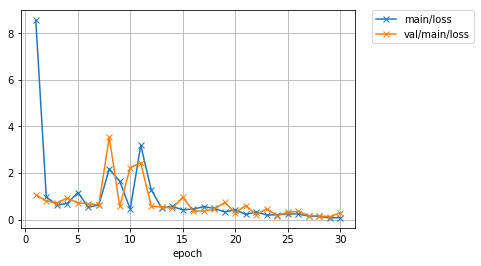

In [34]:
from IPython.display import Image
Image('results/iris_result1/loss.png')

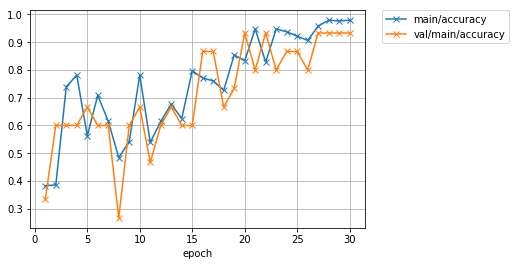

In [35]:
Image('results/iris_result1/accuracy.png')

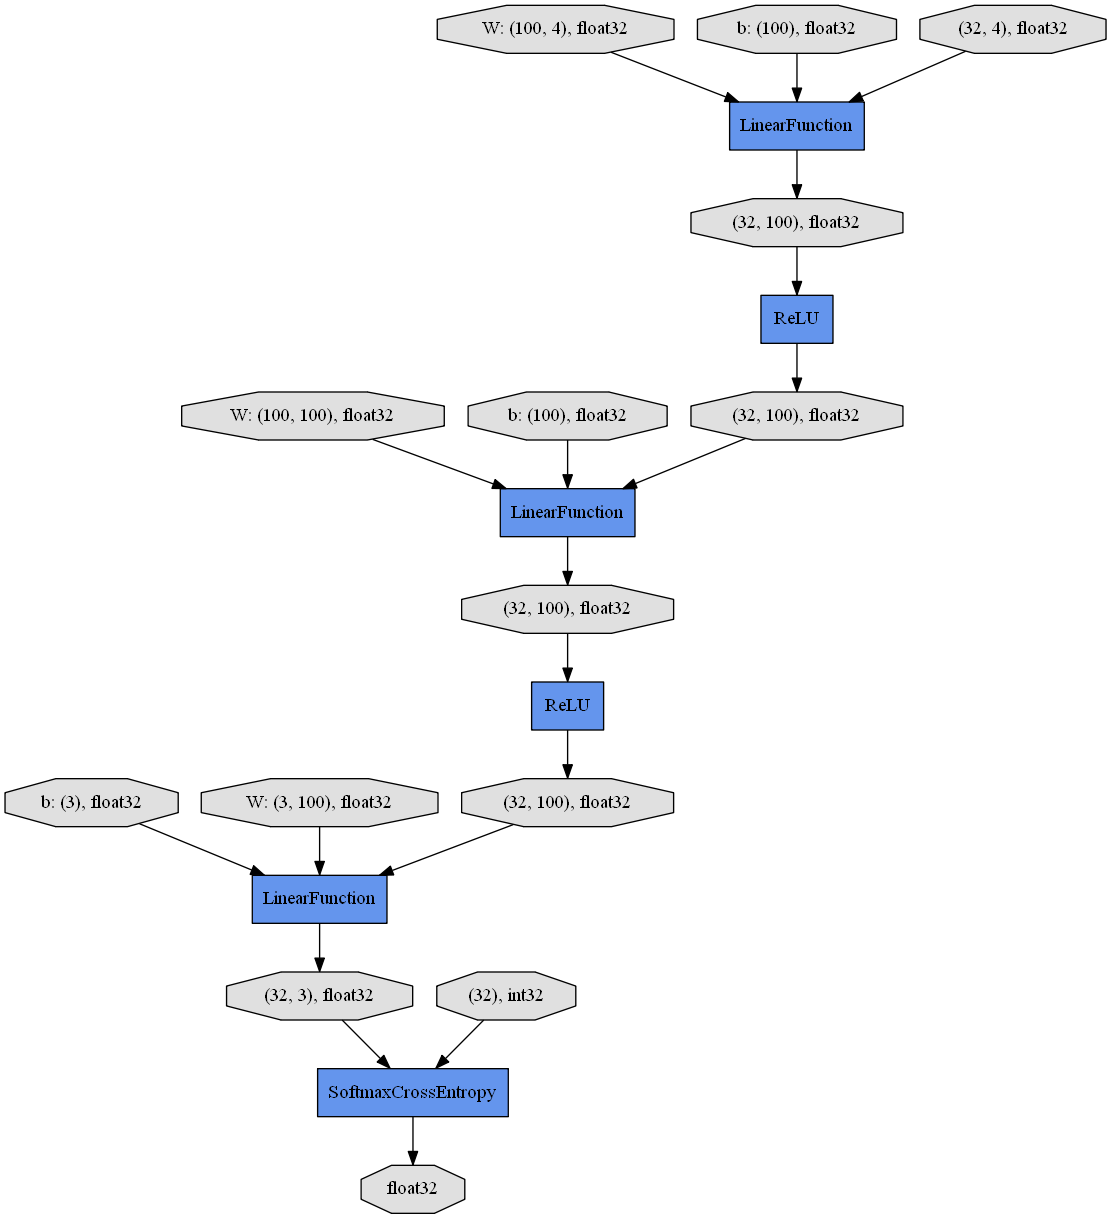

In [36]:
import pydot

file = pydot.graph_from_dot_file('results/iris_result1/cg.dot')
file[0].write_png('graph.png')
Image('graph.png', width=600, height=600)

In [42]:
from chainer import reporter

class MLP2(chainer.Chain):
    
    def __init__(self, n_mid_units=100, n_out=3):
        super().__init__()
        with self.init_scope():
            self.fc1 = L.Linear(None, n_mid_units)
            self.fc2 = L.Linear(n_mid_units, n_mid_units)
            self.fc3 = L.Linear(n_mid_units, n_out)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        reporter.report({'avg_y': F.average(h), 'var_y': F.cross_covariance(h, h)}, self)
        h = self.fc3(h)
        
        return h

In [43]:
net = L.Classifier(MLP2())

optimizer = optimizers.MomentumSGD(lr=0.1).setup(net)

train_iter = SerialIterator(train, 32)

updater = training.StandardUpdater(train_iter, optimizer, device=-1)

trainer = training.Trainer(updater, (30, 'epoch'))

In [44]:
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport([
    'epoch', 'iteration',
    'main/accuracy',
    'main/predictor/avg_y',
    'main/predictor/var_y',
]))

In [45]:
trainer.run()

epoch       iteration   main/accuracy  main/predictor/avg_y  main/predictor/var_y
1           4           0.335938       0.922355              1237.29               
2           7           0.25           0.157664              0.700338              
3           10          0.479167       0.147989              5.73775               
4           14          0.65625        0.170219              52.0137               
5           17          0.677083       0.210993              202.011               
6           20          0.635417       0.163099              242.458               
7           23          0.65625        0.138856              221.887               
8           27          0.570312       0.14738               315.688               
9           30          0.635417       0.112789              67.4216               
10          33          0.666667       0.0780057             135.965               
11          37          0.75           0.0980167             201.037          

In [46]:
net = L.Classifier(MLP())

train_iter = SerialIterator(train, batchsize)
valid_iter = SerialIterator(valid, batchsize, False, False)

In [47]:
optimizer = optimizers.MomentumSGD(lr=0.1).setup(net)
updater = training.StandardUpdater(train_iter, optimizer, device=-1)

In [48]:
from chainer.training.triggers import EarlyStoppingTrigger

trigger = EarlyStoppingTrigger(monitor='val/main/loss', check_trigger=(1, 'epoch'),
                               patients=5, max_trigger=(30, 'epoch'))
trainer = training.Trainer(updater, trigger, out='results/iris_result5')

In [49]:
from chainer.training import extensions

trainer.extend(extensions.LogReport(trigger=(1, 'epoch'), log_name='log'))
trainer.extend(extensions.Evaluator(valid_iter, net, device=-1), name='val')
trainer.extend(extensions.PlotReport(['main/loss', 'val/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'val/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.extend(extensions.PrintReport([
    'epoch', 'main/loss', 'main/accuracy',
    'val/main/loss', 'val/main/accuracy', 'elapsed_time']))

In [50]:
trainer.run()

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           4.82873     0.304688       9.1378         0.4                0.0128074     
2           4.01541     0.333333       0.849302       0.533333           0.17901       
3           0.618174    0.645833       0.600375       0.6                0.340444      
4           0.427918    0.78125        0.269138       0.866667           0.523511      
5           0.248602    0.90625        0.918749       0.666667           0.690808      
6           2.04918     0.697917       0.490843       0.666667           0.867889      
7           0.538431    0.625          0.502301       0.933333           1.08979       
8           0.422036    0.90625        0.331754       0.866667           1.26747       
9           0.279272    0.947917       0.201283       0.933333           1.4424        
10          0.183846    0.947917       0.490837       0.8                1.63531       
11          0.581277    0.804688  

In [51]:
!ls results/iris_result5

accuracy.png
log
loss.png


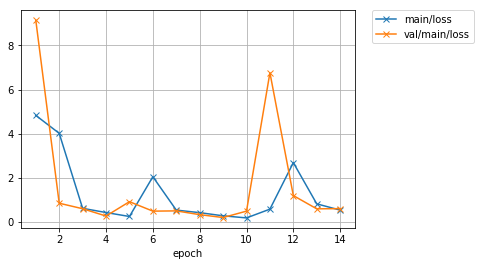

In [52]:
Image('results/iris_result5/loss.png')

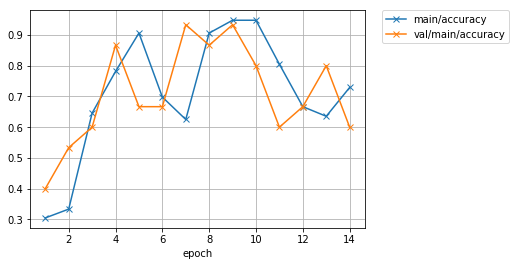

In [53]:
Image('results/iris_result5/accuracy.png')